In [2]:
import cobra

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from cobra.io import read_sbml_model, write_sbml_model
import pandas as pd
from collections import defaultdict
import numpy as np
import cplex

# LOAD, FIX, AND SET MODEL

In [3]:
# Update model to the latest cobrapy standards

import logging
logging.getLogger("cobra").setLevel(logging.ERROR)

model=cobra.io.read_sbml_model("13068_2014_144_MOESM1_ESM.xml")
model.id = "Clostridium"
write_sbml_model(model, "13068_2014_144_MOESM1_ESM_fixed.xml")

In [3]:
model=cobra.io.read_sbml_model("13068_2014_144_MOESM1_ESM_fixed.xml")

In [4]:
# Remove reactions not supported by litterature
Reactions = ["Ex_102","R0013",
            "R0293","R0375","R0376",
            "R0407","R0913","R0976","R1018",
            "R1019","R1141","R1589","R1773",
            "R1779","R1780","R1504"]
for reaction in Reactions:
    reaction = model.reactions.get_by_id(reaction)
    model.remove_reactions([reaction])

In [5]:
# Set direction of relevant exchange reactions
model.reactions.get_by_id("Ex_106").bounds = (0,1000)  #LDH
model.reactions.get_by_id("Ex_96").bounds = (0,1000) #LACTATE
model.reactions.get_by_id("Ex_104").bounds = (0,1000) #CO21
#==========================================
model.reactions.get_by_id("R1583").bounds = (0,1000)  #FNdOR
model.reactions.get_by_id("R1563").bounds = (-1000,1000) #FNOR
model.reactions.get_by_id("R1450").bounds = (0,1000)  #HYDA
model.reactions.get_by_id("Ex_116").bounds = (0,1000) #H2
#==========================================
model.reactions.get_by_id("Ex_110").bounds = (0,1000)  #LDH
model.reactions.get_by_id("Ex_113").bounds = (0,1000) #Ethanol
model.reactions.get_by_id("Ex_111").bounds = (0,1000) #CO21
model.reactions.get_by_id("Ex_103").bounds = (0,1000)

#================================================
model.reactions.get_by_id("R0742").bounds = (0,0) # AOR
model.reactions.get_by_id("Ex_112").bounds = (0,1000) # N2
model.reactions.get_by_id("R1787").bounds = (0,0)
model.reactions.get_by_id("R1483").bounds = (0,0) # 
model.reactions.get_by_id("R0077").bounds = (0,1000)
model.reactions.get_by_id("R1284").bounds = (-1000,0)

#===============================
model.reactions.get_by_id("Ex_15").bounds = (-1000,1000) #Amonio
model.reactions.get_by_id("Ex_49").bounds = (-1000,1000) # Fosfato
model.reactions.get_by_id("Ex_97").bounds = (-1000,1000) # Sulfato
model.reactions.get_by_id("Ex_101").bounds = (-1000,1000) # Agua
model.reactions.get_by_id("Ex_1").bounds = (-1000,1000) # SPF

In [6]:
# Make strain degenerated

Reactions = ["R1423","R1424",
             "R1638","R1654","R1248","R1371"]
for reaction in Reactions:
    reaction = model.reactions.get_by_id(reaction)
    model.remove_reactions([reaction])

In [7]:
cobra.io.write_sbml_model(model, "iCac802_updated.xml")

# FBA

In [8]:
solution=model.optimize()
model.summary()

solution = model.optimize()
print("Biomass =", round(solution["Biomass"],3))
print("Hidrogeno =", round(solution["Ex_116"],3))
print("Lactato =", round(solution["Ex_106"],3))
print("butirato = ",  round(solution["Ex_96"],3))
print("Acetato =", round(solution["Ex_104"],3) )
print("Ethanol =", round(solution["Ex_111"],3) )
print("butanol =", round(solution["Ex_113"],3) )
print("Acetona =", round(solution["Ex_110"],3)) 
print("Co2 =", round(solution["Ex_103"],3))
print("N2 =", round(solution["Ex_112"],3))
print("SPF =", round(solution["Ex_1"],3))

Biomass = 0.3
Hidrogeno = 32.733
Lactato = -0.0
butirato =  0.005
Acetato = 16.27
Ethanol = 0.0
butanol = -0.0
Acetona = -0.0
Co2 = 15.698
N2 = -0.0
SPF = 3.587


# FIND CLOSEST BOUNDS ON EXPERIMENTAL FLUXES

In [9]:
# Experimentally known fluxes
exp = {}
exp["pH5.5"]={}
exp["pH6.0"]={}
exp["pH6.5"]={}
exp["pH5.5"]["Biomass"]=0.1
exp["pH5.5"]["Ex_91"]=-6.5266
exp["pH5.5"]["Ex_116"]=17.71301596
exp["pH5.5"]["Ex_96"]=5.894083885
exp["pH5.5"]["Ex_106"]=0.2987
exp["pH5.5"]["Ex_104"]=5.3782

exp["pH6.0"]["Biomass"]=0.1
exp["pH6.0"]["Ex_91"]=-6.2648
exp["pH6.0"]["Ex_116"]=15.13498271
exp["pH6.0"]["Ex_96"]=5.30159
exp["pH6.0"]["Ex_106"]=0.669710807
exp["pH6.0"]["Ex_104"]=3.1507

exp["pH6.5"]["Biomass"]=0.1
exp["pH6.5"]["Ex_91"]=-8.0258
exp["pH6.5"]["Ex_116"]=15.9725076
exp["pH6.5"]["Ex_96"]=6.3
exp["pH6.5"]["Ex_106"]=3.12144
exp["pH6.5"]["Ex_104"]=2.217

In [10]:
conditions=["pH5.5","pH6.0","pH6.5"]

In [12]:
# FIND THE CLOSSEST v TO THE KNOWN FLUXES
reactionIDs=["Biomass","Ex_91","Ex_96","Ex_106","Ex_104","Ex_116"]

expBF = {} #experimental best fit

for condition in conditions:

    model.reactions.get_by_id("Biomass").bounds =  (exp[condition]["Biomass"], exp[condition]["Biomass"]) # Biomass
    model.reactions.get_by_id("Ex_91").bounds =  (exp[condition]["Ex_91"], exp[condition]["Ex_91"]) # Glucose
    model.solver = 'cplex'
    quadratic_objective = model.problem.Objective(
        ((model.reactions.Ex_96.flux_expression-exp[condition]["Ex_96"])/exp[condition]["Ex_96"])**2 +
        ((model.reactions.Ex_104.flux_expression-exp[condition]["Ex_104"])/exp[condition]["Ex_104"])**2 +
        ((model.reactions.Ex_106.flux_expression-exp[condition]["Ex_106"])/exp[condition]["Ex_106"])**2 +
        ((model.reactions.Ex_116.flux_expression-exp[condition]["Ex_116"])/exp[condition]["Ex_116"])**2,
        direction='min')
    model.objective = quadratic_objective
    solution = model.optimize()
    
    print("Condition ",condition)
    expBF[condition] = {}
    df = pd.DataFrame(columns=["Reaction", "Experimental flux", "Closest flux", "Difference"])
    for reactionID in reactionIDs:
        diff = (solution[reactionID]-exp[condition][reactionID])#/exp[condition][reactionID]*100
        new_row=[reactionID,exp[condition][reactionID],solution[reactionID],round(diff,3)]
        df.loc[len(df)] = new_row
        expBF[condition][reactionID] = solution[reactionID]
    print(df,"\n")


Condition  pH5.5
  Reaction  Experimental flux  Closest flux  Difference
0  Biomass           0.100000      0.100000       0.000
1    Ex_91          -6.526600     -6.526600       0.000
2    Ex_96           5.894084      4.649181      -1.245
3   Ex_106           0.298700      0.296302      -0.002
4   Ex_104           5.378200      5.119071      -0.259
5   Ex_116          17.713016     17.713016       0.000 

Condition  pH6.0
  Reaction  Experimental flux  Closest flux  Difference
0  Biomass           0.100000      0.100000       0.000
1    Ex_91          -6.264800     -6.264800       0.000
2    Ex_96           5.301590      4.493606      -0.808
3   Ex_106           0.669711      0.660041      -0.010
4   Ex_104           3.150700      3.079358      -0.071
5   Ex_116          15.134983     15.134983       0.000 

Condition  pH6.5
  Reaction  Experimental flux  Closest flux  Difference
0  Biomass           0.100000      0.100000       0.000
1    Ex_91          -8.025800     -8.025800      

# Pheflux

In [13]:
# Create uniform transcriptome file. In effect, this reduces Pheflux to MaxEnt
f=open('transcriptome.txt', 'w') 
print("Gene_ID","Expression",sep="\t", file=f)
for gene in model.genes:
    print(gene.id,1,sep="\t", file=f)
f.close()

In [14]:
# Create default medium
f=open('medium.csv', 'w') 
print("Metabolite_Name","Reaction_ID", sep="\t",file=f)
for key in model.medium:
    value=model.medium[key]
    metabolite=model.reactions.get_by_id(key).name.split("[")[0]
    print(metabolite,key,sep="\t", file=f)
f.close()

In [15]:
# Create known fluxes file
for condition in conditions:
    f=open('knownFluxes_'+condition+'.csv', 'w') 
    print("Reaction_ID","Flux",  sep="\t",file=f)
    for reaction in exp[condition]:
        flux=expBF[condition][reaction]
        print(reaction,flux,sep="\t",file=f)
    f.close()

In [17]:
# Create InputData file
for condition in conditions:
    f=open("InputData_"+condition+".csv", 'w') 
    print("Organism\tCondition\tGeneExpFile\tMedium\tNetwork\tKnownFluxes",file=f)
    Organism    ="C_acetobutylicum"
    Condition   =condition
    GeneExpFile ="transcriptome.txt"
    Medium      ="medium.csv"
    Network     ="iCac802_updated.xml"
    KnownFluxes ="knownFluxes_"+condition+".csv"
    print(Organism,Condition,GeneExpFile,Medium,Network,KnownFluxes,sep="\t",file=f)
    f.close()

In [19]:
#import pheflux_one as pheflux
import pheflux

In [20]:
for condition in conditions:
    print(condition)
    inputFile       = "InputData_"+condition+".csv"
    resultsDir      = "./results_paper"
    verbosity       = False # Verbose mode
    prefix_log_file = condition
    print(inputFile)
    pheflux.getFluxes(inputFile,resultsDir)

pH5.5
InputData_pH5.5.csv
Condition ejecuted: C_acetobutylicum - pH5.5 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:     2013
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2013
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1259
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constrai

In [21]:
fluxes_pH55=pd.read_csv("./results/pH5.5_Solved_To_Acceptable_Level.csv",sep="\t",
                   names=["ReactionID","Flux"],header=0,index_col=0)
fluxes_pH60=pd.read_csv("./results/pH6.0_Solved_To_Acceptable_Level.csv",sep="\t",
                   names=["ReactionID","Flux"],header=0,index_col=0)
fluxes_pH65=pd.read_csv("./results/pH6.5_Solved_To_Acceptable_Level.csv",sep="\t",
                   names=["ReactionID","Flux"],header=0,index_col=0)


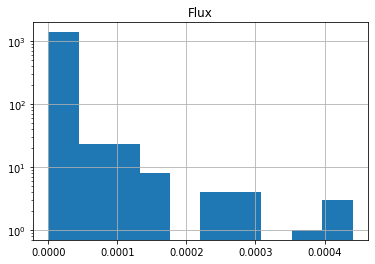

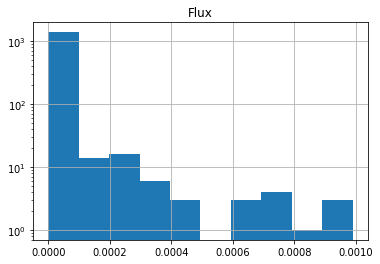

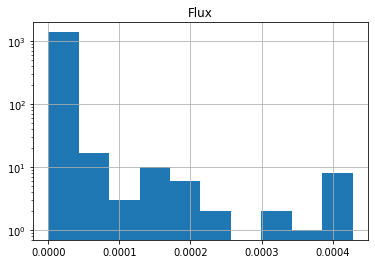

In [22]:
# Explore flux distributions

abs(fluxes_pH55).hist(log=True)
plt.show()
abs(fluxes_pH60).hist(log=True)
plt.show()
abs(fluxes_pH65).hist(log=True)
plt.show()

In [23]:
# Reactions consuming and producing ATP

# Acetate producing ATP
    # R0602 #ACK
# Butyrate producing ATP
    # R1148 #BUK
# Glycolisis consuming ATP
    # R0146 #Phosphofructokinase-1 -ATP
    # R0943 #Hexokinase -ATP
# Glycolisis producing ATP
    # R0379 #Pyruvate kinase glycolysis +ATP
    # R0239 #Phosphoglycerate kinase +ATP

reactionIDs=["R0602","R1148","R0146","R0943","R0379","R0239"]

In [26]:
fluxesConds = [fluxes_pH55,fluxes_pH60,fluxes_pH65]
atp=model.metabolites.cpd00002_c
nadh=model.metabolites.cpd00004_c

knownRxnIDs=["Biomass","Ex_91","Ex_116","Ex_96","Ex_104","Ex_106"]#,"R0943"]


for i,condition in enumerate(conditions):
    print(condition,"\n===========================")
    print("Reaction\tExperimental\tPredicted\Difference")
    fluxes = fluxesConds[i]
    scale = 0.1/fluxes.loc["R_Biomass"].Flux
    fluxesScaled = fluxes*scale
            
    for knownRxnID in knownRxnIDs:
        predicted    = fluxesScaled.loc["R_"+knownRxnID]["Flux"]
        fluxExp=exp[condition][knownRxnID] 
        diff = (predicted-fluxExp)/fluxExp*100
        print(knownRxnID,fluxExp,predicted,diff,sep="\t")
    print("===========================\n")

pH5.5 
Reaction	Experimental	Predicted\Difference
Biomass	0.1	0.1	0.0
Ex_91	-6.5266	-6.526214385974961	-0.005908344697688506
Ex_116	17.71301596	17.713017264461424	7.364423016146384e-06
Ex_96	5.894083885	4.64956783463887	-21.114664715382304
Ex_104	5.3782	5.1192001698738	-4.815734448815589
Ex_106	0.2987	0.29649560116174356	-0.7379976023623904

pH6.0 
Reaction	Experimental	Predicted\Difference
Biomass	0.1	0.1	0.0
Ex_91	-6.2648	-6.263793566285229	-0.016064897758444784
Ex_116	15.13498271	15.134989295618126	4.351255798213584e-05
Ex_96	5.30159	4.494619152465355	-15.22129865822602
Ex_104	3.1507	3.0796994801559534	-2.2534839827354762
Ex_106	0.669710807	0.6605484684965265	-1.3681037259226247

pH6.5 
Reaction	Experimental	Predicted\Difference
Biomass	0.1	0.10000000000000002	1.3877787807814457e-14
Ex_91	-8.0258	-8.025466954452094	-0.004149686609512475
Ex_116	15.9725076	15.972174396027372	-0.00208610933845154
Ex_96	6.3	5.607054588410949	-10.99913351728652
Ex_104	2.217	2.1957960394172833	-0.95642582

In [27]:
ATP_rxns=pd.read_csv("ATP_reactions.tsv",sep="\t",names=["Class"],header=0)

In [28]:
NADH_rxns=pd.read_csv("NADH_reactions.tsv",sep="\t",names=["Class"],header=0)

pH5.5 
R0602	5.1192285676398415
R1148	4.649575558088921
R0146	-4.0570426335893615
R0943	-6.148985676780796
R0379	10.61848305194516
R0239	-0.0
ATP net flux	10.181258867303766
Total ATP prod	32.125242378096154
Yield	4.922492654720982


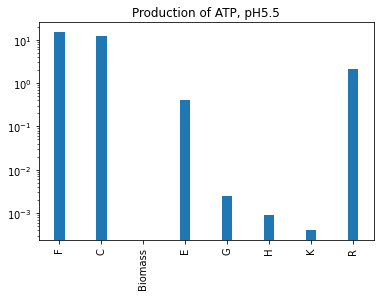

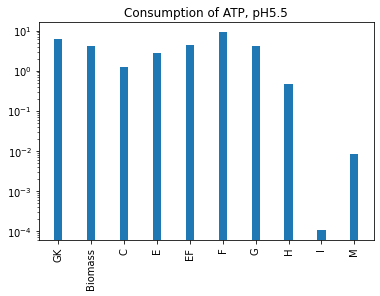


pH6.0 
R0602	3.079874898347308
R1148	4.494639396654471
R0146	-5.207473102261896
R0943	-5.207534746446364
R0379	10.555358137127227
R0239	-0.0
ATP net flux	7.714864583420746
Total ATP prod	23.265487797472947
Yield	3.7142807391832116


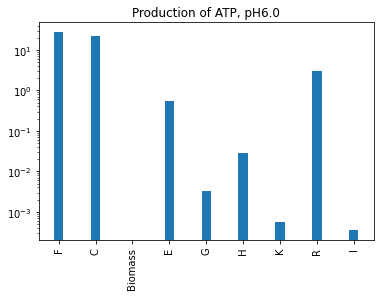

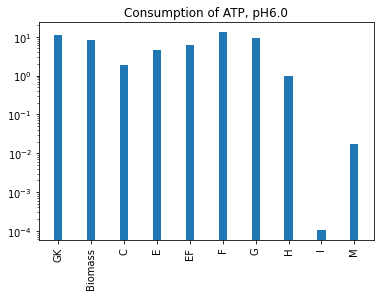


pH6.5 
R0602	2.1960843383308735
R1148	5.607078288967121
R0146	-7.206798181514899
R0943	-7.2857145284563956
R0379	14.834090096826026
R0239	-0.0
ATP net flux	8.144740014152726
Total ATP prod	27.049071667509104
Yield	3.3704047155167394


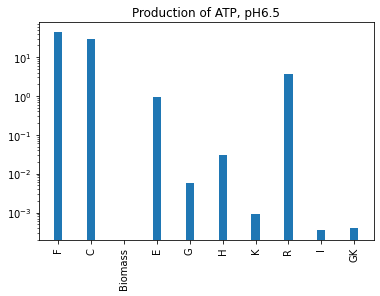

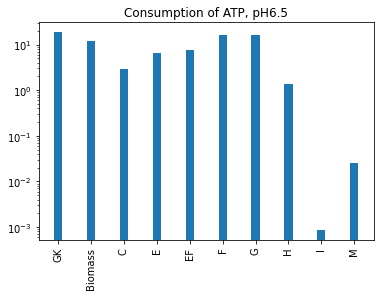

In [29]:
Production_ATP =defaultdict(float)
Consumo_ATP =defaultdict(float)

width=0.25

for i,condition in enumerate(conditions):
    print(condition,"\n===========================")
    fluxes = fluxesConds[i]
    scale = 0.1/fluxes.loc["R_Biomass"].Flux
    fluxesScaled = fluxes*scale    
    ABLFlux = 0
    for reactionID in reactionIDs:
        reaction = model.reactions.get_by_id(reactionID)
        coef     = reaction.metabolites[atp]
        flux     = fluxesScaled.loc["R_"+reactionID]["Flux"]*coef
        ABLFlux += flux
        print(reactionID,flux,sep="\t")
    totalFlux=0
    for reaction in model.metabolites.cpd00002_c.reactions:
        coef     = reaction.metabolites[atp]
        flux     = fluxesScaled.loc["R_"+reaction.id]["Flux"]*coef
        if flux>0:
            totalFlux += flux
    #NADH flux
    totalNADHFlux=0
    for reaction in model.metabolites.cpd00004_c.reactions:
        coef     = reaction.metabolites[nadh]
        flux     = fluxesScaled.loc["R_"+reaction.id]["Flux"]*coef
        if flux>0:
            totalNADHFlux += flux
            
    print("ATP net flux",ABLFlux,sep="\t")
    print("Total ATP prod",totalFlux,sep="\t")
    y = totalFlux/abs(fluxesScaled.loc["R_Ex_91"]["Flux"])
    print("Yield",y,sep="\t")
    
    for reactionID in ATP_rxns.index:
        Class    =ATP_rxns.loc[reactionID].Class
        reaction = model.reactions.get_by_id(reactionID)
        coef     = reaction.metabolites[atp]
        flux     = fluxesScaled.loc["R_"+reactionID]["Flux"]*coef
        if flux>=0:
            Production_ATP[Class] += flux
        else:
            Consumo_ATP[Class] += flux


    plt.bar(list(Production_ATP.keys()),np.abs(list(Production_ATP.values())),width,log=True )
    y_pos = range(len(Production_ATP))
    plt.xticks(y_pos, list(Production_ATP.keys()), rotation=90)
    plt.title("Production of ATP, "+condition)
    plt.show()
    

    plt.title("Consumption of ATP, "+condition)
    plt.bar(list(Consumo_ATP.keys()),np.abs(list(Consumo_ATP.values())),width,log=True )
    y_pos = range(len(Consumo_ATP))
    plt.xticks(y_pos, list(Consumo_ATP.keys()), rotation=90)
    plt.show()
    print("===========================\n")


In [30]:
Production_ATP={}
Consumo_ATP={}
Production_NADH={}
Consumo_NADH={}
y={} #yield
y_nadh={} #yield NADH
totalFlux={} #netFlux ATP
totalFlux_nadh={} # netflux NADH
synthase={}  
spf={}

width=0.25

for i,condition in enumerate(conditions):
    print(condition,"\n===========================")
    
    fluxes = fluxesConds[i]
    scale = 0.1/fluxes.loc["R_Biomass"].Flux
    fluxesScaled = fluxes*scale    
    ABLFlux = 0
    for reactionID in reactionIDs:
        reaction = model.reactions.get_by_id(reactionID)
        coef     = reaction.metabolites[atp]
        flux     = fluxesScaled.loc["R_"+reactionID]["Flux"]*coef
        ABLFlux += flux
        print(reactionID,flux,sep="\t")
    print("ATP net flux",ABLFlux,sep="\t")
    
    totalFlux[condition]=0
    for reaction in model.metabolites.cpd00002_c.reactions:
        coef     = reaction.metabolites[atp]
        flux     = fluxesScaled.loc["R_"+reaction.id]["Flux"]*coef
        if flux>0:
            totalFlux[condition] += flux
    print("Total ATP prod",totalFlux[condition],sep="\t")
    
    totalFlux_nadh[condition]=0
    for reaction in model.metabolites.cpd00004_c.reactions:
        coef     = reaction.metabolites[nadh]
        flux     = fluxesScaled.loc["R_"+reaction.id]["Flux"]*coef
        if flux>0:
            totalFlux_nadh[condition] += flux
    print("Total NADH prod",totalFlux_nadh[condition],sep="\t")    
    
    y[condition] = totalFlux[condition]/abs(fluxesScaled.loc["R_Ex_91"]["Flux"])
    y_nadh[condition] = totalFlux_nadh[condition]/abs(fluxesScaled.loc["R_Ex_91"]["Flux"])

    print("Yield",y[condition],sep="\t")
    
    synthase[condition]=fluxesScaled.loc["R_R1045"].Flux
    spf[condition]     =fluxesScaled.loc["R_Ex_1"].Flux
    
    Production_ATP[condition] =defaultdict(float)
    Consumo_ATP[condition] =defaultdict(float)
    for reactionID in ATP_rxns.index:
        Class    = ATP_rxns.loc[reactionID].Class
        reaction = model.reactions.get_by_id(reactionID)
        coef     = reaction.metabolites[atp]
        flux     = fluxesScaled.loc["R_"+reactionID]["Flux"]*coef
        if flux>=0:
            Production_ATP[condition][Class] += flux
            Consumo_ATP[condition][Class] += 0
        else:
            Production_ATP[condition][Class] += 0
            Consumo_ATP[condition][Class] += flux
            
    Production_NADH[condition] =defaultdict(float)
    Consumo_NADH[condition] =defaultdict(float)
    for reactionID in NADH_rxns.index:
        Class    = NADH_rxns.loc[reactionID].Class
        reaction = model.reactions.get_by_id(reactionID)
        coef     = reaction.metabolites[nadh]
        flux     = fluxesScaled.loc["R_"+reactionID]["Flux"]*coef
        if flux>=0:
            Production_NADH[condition][Class] += flux
            Consumo_NADH[condition][Class] += 0
        else:
            Production_NADH[condition][Class] += 0
            Consumo_NADH[condition][Class] += flux

pH5.5 
R0602	5.1192285676398415
R1148	4.649575558088921
R0146	-4.0570426335893615
R0943	-6.148985676780796
R0379	10.61848305194516
R0239	-0.0
ATP net flux	10.181258867303766
Total ATP prod	32.125242378096154
Total NADH prod	25.298092410908705
Yield	4.922492654720982
pH6.0 
R0602	3.079874898347308
R1148	4.494639396654471
R0146	-5.207473102261896
R0943	-5.207534746446364
R0379	10.555358137127227
R0239	-0.0
ATP net flux	7.714864583420746
Total ATP prod	23.265487797472947
Total NADH prod	22.511281160188176
Yield	3.7142807391832116
pH6.5 
R0602	2.1960843383308735
R1148	5.607078288967121
R0146	-7.206798181514899
R0943	-7.2857145284563956
R0379	14.834090096826026
R0239	-0.0
ATP net flux	8.144740014152726
Total ATP prod	27.049071667509104
Total NADH prod	27.79243586294557
Yield	3.3704047155167394


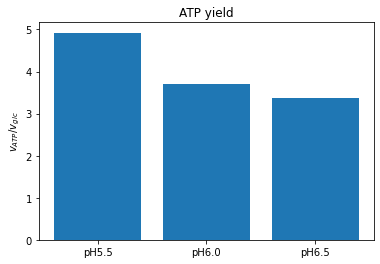

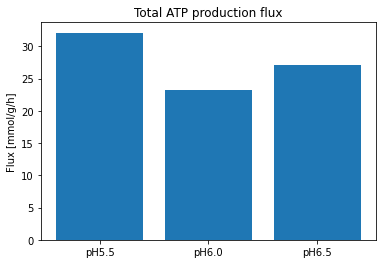

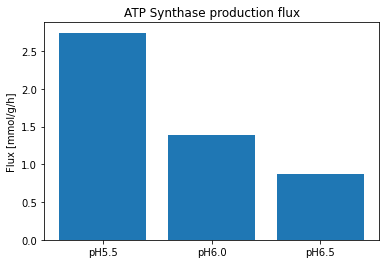

In [31]:
plt.bar(y.keys(),np.abs(list(y.values())),log=False )
plt.title("ATP yield")
plt.ylabel("$v_{ATP}/v_{glc}$")
plt.show()

f=totalFlux
plt.bar(f.keys(),np.abs(list(f.values())),log=False )
plt.title("Total ATP production flux")
plt.ylabel("Flux [mmol/g/h]")
plt.show()

plt.bar(synthase.keys(),list(synthase.values()),log=False )
plt.title("ATP Synthase production flux")
plt.ylabel("Flux [mmol/g/h]")
plt.show()
 

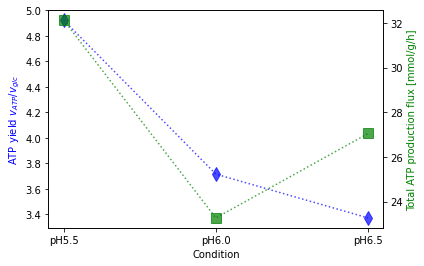

In [43]:
fig, ax1 = plt.subplots() 

ax1.plot(y.keys(),np.abs(list(y.values())),"d:",color="blue",alpha=0.7,markersize=10 )
#ax1.set_title("ATP yield")
ax1.set_ylabel("ATP yield $v_{ATP}/v_{glc}$",color="blue")
ax1.set_xlabel("Condition")

ax2 = ax1.twinx() 

f=totalFlux
ax2.plot(f.keys(),np.abs(list(f.values())),"s:",color="green",alpha=0.7,markersize=10 )
ax2.set_ylabel("Total ATP production flux [mmol/g/h]",color="green")

plt.savefig("fig6a.svg")
plt.savefig("fig6a.png", dpi=300)
plt.show()

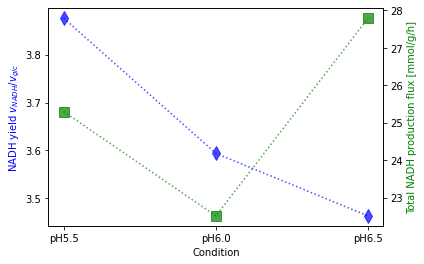

In [42]:
fig, ax1 = plt.subplots() 

ax1.plot(y_nadh.keys(),np.abs(list(y_nadh.values())),"d:",color="blue",alpha=0.7,markersize=10 )
#ax1.set_title("ATP yield")
ax1.set_ylabel("NADH yield $v_{NADH}/v_{glc}$",color="blue")
ax1.set_xlabel("Condition")

ax2 = ax1.twinx() 

f=totalFlux_nadh
ax2.plot(f.keys(),np.abs(list(f.values())),"s:",color="green",alpha=0.7,markersize=10 )
ax2.set_ylabel("Total NADH production flux [mmol/g/h]",color="green")

plt.savefig("fig6b.svg")
plt.savefig("fig6b.png", dpi=300)
plt.show()

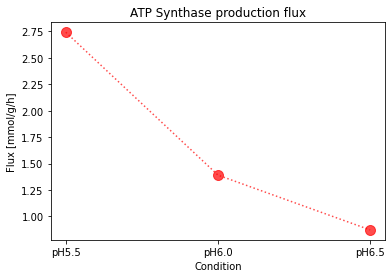

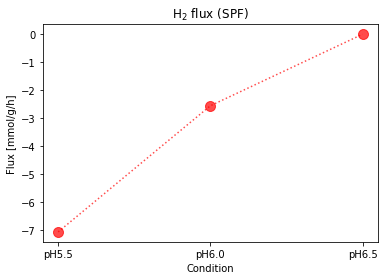

In [44]:
plt.plot(synthase.keys(),list(synthase.values()),"o:",color="red",alpha=0.7,markersize=10 )
plt.title("ATP Synthase production flux")
plt.ylabel("Flux [mmol/g/h]")
plt.xlabel("Condition")
plt.savefig("fig4b.svg")
plt.savefig("fig4b.png",dpi=300)
plt.show()

plt.plot(spf.keys(),list(spf.values()),"o:",color="red",alpha=0.7,markersize=10 )
plt.title("H${}_2$ flux (SPF)")
plt.ylabel("Flux [mmol/g/h]")
plt.xlabel("Condition")
plt.savefig("spf.svg")
plt.show()

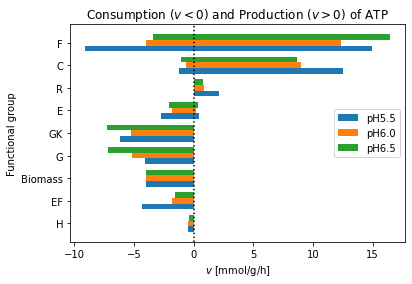

In [45]:
keys=["F","C","R","E","GK","G","Biomass","EF","H"][::-1] #,"M","K","I"

for i,condition in enumerate(conditions):
    P_ATP =[Production_ATP[condition][key] for key in keys]
    C_ATP =[Consumo_ATP[condition][key] for key in keys]
    
    ind = np.arange(len(P_ATP))
    plt.barh(list(ind+width*i)+list(ind+width*i),P_ATP+C_ATP,width,log=False )

plt.legend(  conditions,loc='center right' )
plt.axvline(x=0,color="black",linestyle="dotted")
plt.yticks(ind+width, keys)
plt.title("Consumption ($v<0$) and Production ($v>0$) of ATP")
plt.xlabel("$v$ [mmol/g/h]")
plt.ylabel("Functional group")  
plt.savefig("fig5a.svg")  
plt.savefig("fig5a.png",dpi=300)  
plt.show()

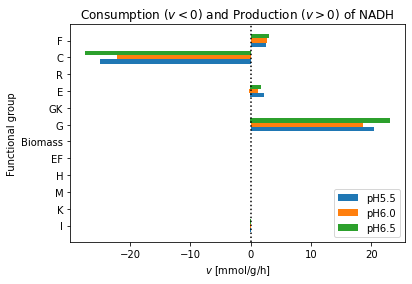

In [46]:
keys=["F","C","R","E","GK","G","Biomass","EF","H","M","K","I"][::-1] #,"M","K","I"

for i,condition in enumerate(conditions):
    P_NADH =[Production_NADH[condition][key] for key in keys]
    C_NADH =[Consumo_NADH[condition][key] for key in keys]
    
    ind = np.arange(len(P_NADH))
    plt.barh(list(ind+width*i)+list(ind+width*i),P_NADH+C_NADH,width,log=False )

plt.legend(  conditions,loc='lower right' )
plt.axvline(x=0,color="black",linestyle="dotted")
plt.yticks(ind+width, keys)
plt.title("Consumption ($v<0$) and Production ($v>0$) of NADH")
plt.xlabel("$v$ [mmol/g/h]")
plt.ylabel("Functional group")  
plt.savefig("fig5b.svg")  
plt.savefig("fig5b.png",dpi=300)  
plt.show()